# 비디오와 정량 지표 변화 같이 나타내기

In [1]:
url = 'https://www.youtube.com/watch?v=2SATljljXCY'
import utils, cv2
cap = utils.openVideoStream(url)
# utils.extractFrames(cap, 0, None, cap.get(cv2.CAP_PROP_FPS), './sing')
utils.extractFrames(cap, 0, None, cap.get(cv2.CAP_PROP_FPS), './sing')

'https://www.youtube.com/watch?v=2SATljljXCY'에서 progressive 720p 스트림 URL을 가져오는 중...
⚠️ 720p @30fps progressive 스트림 없음 → fallback으로 최대 해상도 progressive 선택
🎬 선택된 스트림: mp4 | 360p @ 25fps
URL: https://rr5---sn-n3cgv5qc5oq-bh2sr.googlevideo.com/videoplayback?expire=1753098911&ei=P9Z9aK7xMIvd1d8P96OL0A4&ip=163.180.118.139&id=o-AH1nT0SzWmZTEzELPCjRSBrykkDUMeIEAMfmzgFApK_S&itag=18&source=youtube&requiressl=yes&xpc=EgVo2aDSNQ%3D%3D&met=1753077311%2C&mh=de&mm=31%2C26&mn=sn-n3cgv5qc5oq-bh2sr%2Csn-3pm7dnl7&ms=au%2Conr&mv=m&mvi=5&pcm2cms=yes&pl=19&rms=au%2Cau&initcwndbps=4250000&bui=AY1jyLNSGQAEwfus4N9EAT1xhFCLToyrf1r-_HNkah9KSwAl6ZPnVy9XVjslwuF7jtX9rz28ptOMDrxq&vprv=1&svpuc=1&mime=video%2Fmp4&ns=Th9scszQCyNonnP5xlmuvBoQ&rqh=1&cnr=14&ratebypass=yes&dur=53.057&lmt=1664743344861064&mt=1753076969&fvip=1&lmw=1&fexp=51543007&c=TVHTML5&sefc=1&txp=5538434&n=H8BBxVvRLy_hRA&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cxpc%2Cbui%2Cvprv%2Csvpuc%2Cmime%2Cns%2Crqh%2Ccnr%2Cratebypass%2Cdur%2Clmt&s

1325

시각
- TI(Optical Flow)
- SI

청각
- 음 종류
- 스피치
    - 조음속도
- 음악
    - 템포
    - 볼륨
    - 에너지

In [2]:
import utils
si = utils.calculateSI('./sing')
optic_flow = utils.calculateOpticalFlow('./sing')
ti = utils.calculateTI('./sing')

Calculating SI:   0%|          | 0/1325 [00:00<?, ?it/s]

Calculating Optical Flow: 100%|██████████| 1325/1325 [00:02<00:00, 659.85it/s]


[Optical Flow] 보간된 프레임 수: 1개
[Optical Flow] 보간된 프레임 인덱스: [949]


Calculating TI: 100%|██████████| 1325/1325 [00:00<00:00, 1604.53it/s]


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
import matplotlib as mpl
from tqdm import tqdm
from panns_inference import SoundEventDetection, labels


def play_video_with_audio_and_metrics(
    cap, audio, si, ti, optic_flow,
    device='cpu',
    min_score=0.2,
    window_size=5,
    output_path="output"
):
    mpl.rcParams['animation.embed_limit'] = 50_000_000

    def get_window_range(current_time, duration, window_size):
        if current_time > window_size / 2:
            left = max(0, current_time - window_size / 2)
            right = min(duration, left + window_size)
        else:
            left, right = 0, window_size
        return left, right

    def update_cursor_and_xlim(current_time, duration, window_size, cursors, axes):
        left, right = get_window_range(current_time, duration, window_size)
        for cursor in cursors:
            cursor.set_xdata([current_time, current_time])
        for ax in axes:
            ax.set_xlim(left, right)

    def init_metric_plot(ax, x, y, color, ylabel):
        ax.plot(x, y, color=color)
        cursor = ax.axvline(x=0, color='r', linestyle='--')
        ax.set_xlim(0, window_size)
        ax.set_ylim(np.min(y) - 5, np.max(y) + 5)
        ax.set_ylabel(ylabel)
        ax.grid(True)
        return cursor

    # 1. 사운드 이벤트 추론
    sr = 32000
    sed = SoundEventDetection(checkpoint_path=None, device=device)
    framewise_output = sed.inference(audio)[0]  # (T, 527)

    max_scores = np.max(framewise_output, axis=0)
    top_indices = np.where(max_scores >= min_score)[0]

    if len(top_indices) == 0:
        print(f"\n❗ 최대 확률이 {min_score} 이상인 클래스가 없습니다.")
        return

    print(f"\n🎧 최대 확률이 {min_score} 이상인 클래스 수: {len(top_indices)}개")
    for idx in top_indices[np.argsort(max_scores[top_indices])[::-1]]:
        print(f"- {labels[idx]}: 최대 {max_scores[idx]:.3f}")

    # 2. 영상 프레임 로딩
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []

    with tqdm(total=total_frame, desc="Loading video frames") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
            pbar.update(1)
    cap.release()

    # 3. 오디오 확률 보간
    T, _ = framewise_output.shape
    K = len(top_indices)
    x_old = np.linspace(0, total_frame - 1, T)
    x_new = np.arange(total_frame)

    framewise_resampled = np.zeros((total_frame, K))
    for i, k in enumerate(tqdm(top_indices, desc="Interpolating audio probs")):
        framewise_resampled[:, i] = np.interp(x_new, x_old, framewise_output[:, k])

    # 4. 시각화 설정
    x_time = np.arange(total_frame) / fps
    x_time_ti = x_time[:-1]
    duration = x_time[-1]

    fig = plt.figure(figsize=(15, 7))
    gs = gridspec.GridSpec(3, 6, width_ratios=[1, 1, 1, 1, 1, 1])  # 2칸씩 균등분할 (2:2:2)

    # 왼쪽: 오디오
    ax_audio = fig.add_subplot(gs[:, 0:2])
    audio_lines = []
    for i in range(K):
        line, = ax_audio.plot(x_time, framewise_resampled[:, i], label=labels[top_indices[i]])
        audio_lines.append(line)
    cursor_audio = ax_audio.axvline(x=0, color='r', linestyle='--')
    ax_audio.set_ylim(0, 1)
    ax_audio.set_xlim(0, window_size)
    ax_audio.set_ylabel("Audio Prob")
    ax_audio.set_xlabel("Time (s)")
    ax_audio.grid(True)
    ax_audio.legend(fontsize=6)

    # 중앙: 비디오
    ax_video = fig.add_subplot(gs[:, 2:4])
    img_disp = ax_video.imshow(frames[0])
    ax_video.axis('off')
    ax_video.set_title("Video")

    # 오른쪽: SI, TI, OF
    ax_si = fig.add_subplot(gs[0, 4:6])
    cursor_si = init_metric_plot(ax_si, x_time, si, 'blue', "SI")

    ax_ti = fig.add_subplot(gs[1, 4:6])
    cursor_ti = init_metric_plot(ax_ti, x_time_ti, ti, 'green', "TI")

    ax_of = fig.add_subplot(gs[2, 4:6])
    cursor_of = init_metric_plot(ax_of, x_time_ti, optic_flow, 'orange', "Optical Flow")
    ax_of.set_xlabel("Time (s)")

    # 5. 애니메이션 업데이트
    def update(frame_idx):
        current_time = frame_idx / fps
        img_disp.set_data(frames[frame_idx])
        update_cursor_and_xlim(
            current_time, duration, window_size,
            cursors=[cursor_audio, cursor_si, cursor_ti, cursor_of],
            axes=[ax_audio, ax_si, ax_ti, ax_of]
        )
        return [img_disp, cursor_audio, cursor_si, cursor_ti, cursor_of] + audio_lines

    # 6. 저장
    ani = animation.FuncAnimation(
        fig, update,
        frames=len(frames),
        interval=1000 / fps,
        blit=False
    )

    with tqdm(total=len(frames), desc="Rendering frames") as pbar:
        def _progress(i, n):
            pbar.update(i - pbar.n)

        ani.save(f"{output_path}.mp4", fps=fps, dpi=150, progress_callback=_progress)


'https://www.youtube.com/watch?v=2SATljljXCY'에서 progressive 720p 스트림 URL을 가져오는 중...
⚠️ 720p @30fps progressive 스트림 없음 → fallback으로 최대 해상도 progressive 선택
🎬 선택된 스트림: mp4 | 360p @ 25fps
URL: https://rr5---sn-n3cgv5qc5oq-bh2sr.googlevideo.com/videoplayback?expire=1753099969&ei=Ydp9aJ_lApXR29gP2tGF8QQ&ip=163.180.118.139&id=o-AKOFSCe0FrJUger6dqMiDlQ7xZHJaiNbUxzpLEGlSydu&itag=18&source=youtube&requiressl=yes&xpc=EgVo2aDSNQ%3D%3D&met=1753078369%2C&mh=de&mm=31%2C26&mn=sn-n3cgv5qc5oq-bh2sr%2Csn-3pm7kn76&ms=au%2Conr&mv=m&mvi=5&pl=19&rms=au%2Cau&initcwndbps=3650000&bui=AY1jyLM33RdDKhu_YZxAgiTzPgac99xHptDdjqCPo2-SM1KkoQqVXVB6fpZohLOUruzpZxiykBlxzihc&vprv=1&svpuc=1&mime=video%2Fmp4&ns=XI4BGSVdwzQfP-d3MOLUFEUQ&rqh=1&cnr=14&ratebypass=yes&dur=53.057&lmt=1664743344861064&mt=1753077925&fvip=3&lmw=1&fexp=51543007&c=TVHTML5&sefc=1&txp=5538434&n=cFhGmYab041CTA&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cxpc%2Cbui%2Cvprv%2Csvpuc%2Cmime%2Cns%2Crqh%2Ccnr%2Cratebypass%2Cdur%2Clmt&sig=AJfQdSswR

Rendering frames: 100%|█████████▉| 1324/1325 [05:15<00:00,  4.20it/s]


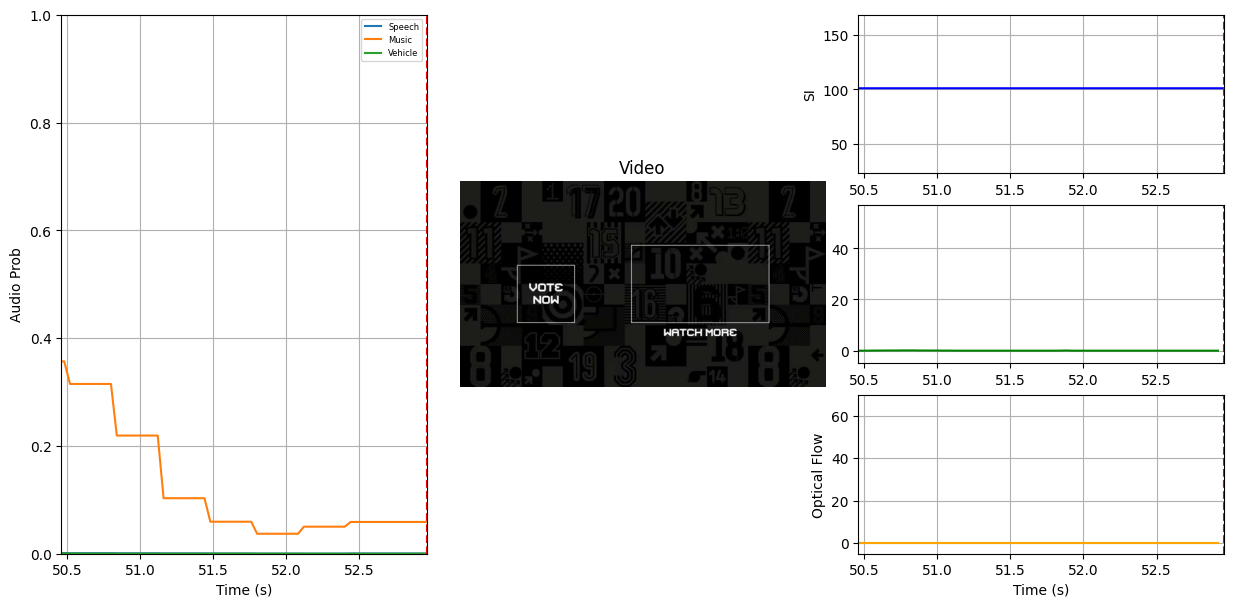

In [ ]:
url = 'https://www.youtube.com/watch?v=2SATljljXCY'
cap = utils.openVideoStream(url)
audio, sr = utils.getAudioCroppedFromURL(url)
output_path = './son'
play_video_with_audio_and_metrics(
    cap, audio, si, ti, optic_flow,
    device='cuda',
    output_path=output_path
)

In [ ]:
# 소리 추가

import soundfile as sf
import os
import subprocess

output_path = './son'

input_video = f'{output_path}.mp4'
final_video = f'{output_path}_new.mp4'

sf.write("temp_audio.wav", audio.T if audio.ndim == 2 else audio, sr)

cmd = [
    "ffmpeg", "-y",
    "-i", input_video,              # 기존 비디오 (음소거)
    "-i", "temp_audio.wav",         # 새 오디오
    "-c:v", "copy",                 # 비디오는 그대로 복사
    "-c:a", "aac",                  # 오디오는 aac로 인코딩
    "-map", "0:v:0",                # 첫 번째 입력의 비디오만 사용
    "-map", "1:a:0",                # 두 번째 입력의 오디오만 사용
    final_video                     # 출력 파일 이름
]

subprocess.run(cmd)

os.remove(input_video)
os.remove("temp_audio.wav")
os.rename(final_video, input_video)